### I. Import data and libraries:

In [1]:
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Show TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if TensorFlow is using GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU")
    print("GPU devices:", tf.config.list_physical_devices('GPU'))
else:
    print("TensorFlow is not using GPU")

TensorFlow version: 2.10.0
TensorFlow is using GPU
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_path = r"C:\D\AI\Dataset\Dataset small\tomato"

image_sizes = set()

def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_path = os.path.join(root, file)
            size = get_image_size(image_path)
            image_sizes.add(size)

for size in image_sizes:
    print(f"Image size: {size}")
print("Number of image size:", len(image_sizes))

Image size: (256, 256)
Number of image size: 1


### II. Data exploration

In [2]:
batch_size = 32
img_height = 299
img_width = 299

In [3]:
train_data = tf.keras.utils.image_dataset_from_directory(
    r"C:\D\AI\Dataset\Dataset small\tomato\train",
    color_mode = 'rgb',
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10000 files belonging to 10 classes.


In [4]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\D\AI\Dataset\Dataset small\tomato\val",
    color_mode = 'rgb',
    image_size = (img_height, img_width),
    batch_size = batch_size) 

Found 1000 files belonging to 10 classes.


In [ ]:
class_names = train_data.class_names
print(f"Number of classes: {len(class_names)}")
list_class = class_names
class_names

Number of classes: 10


['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [8]:
print(f"Type of train_data: {type(train_data)}")
print(f"Details of train_data: {train_data}")
print(f"Element specification of train_data: {train_data.element_spec}")

Type of train_data: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Details of train_data: <BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Element specification of train_data: (TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


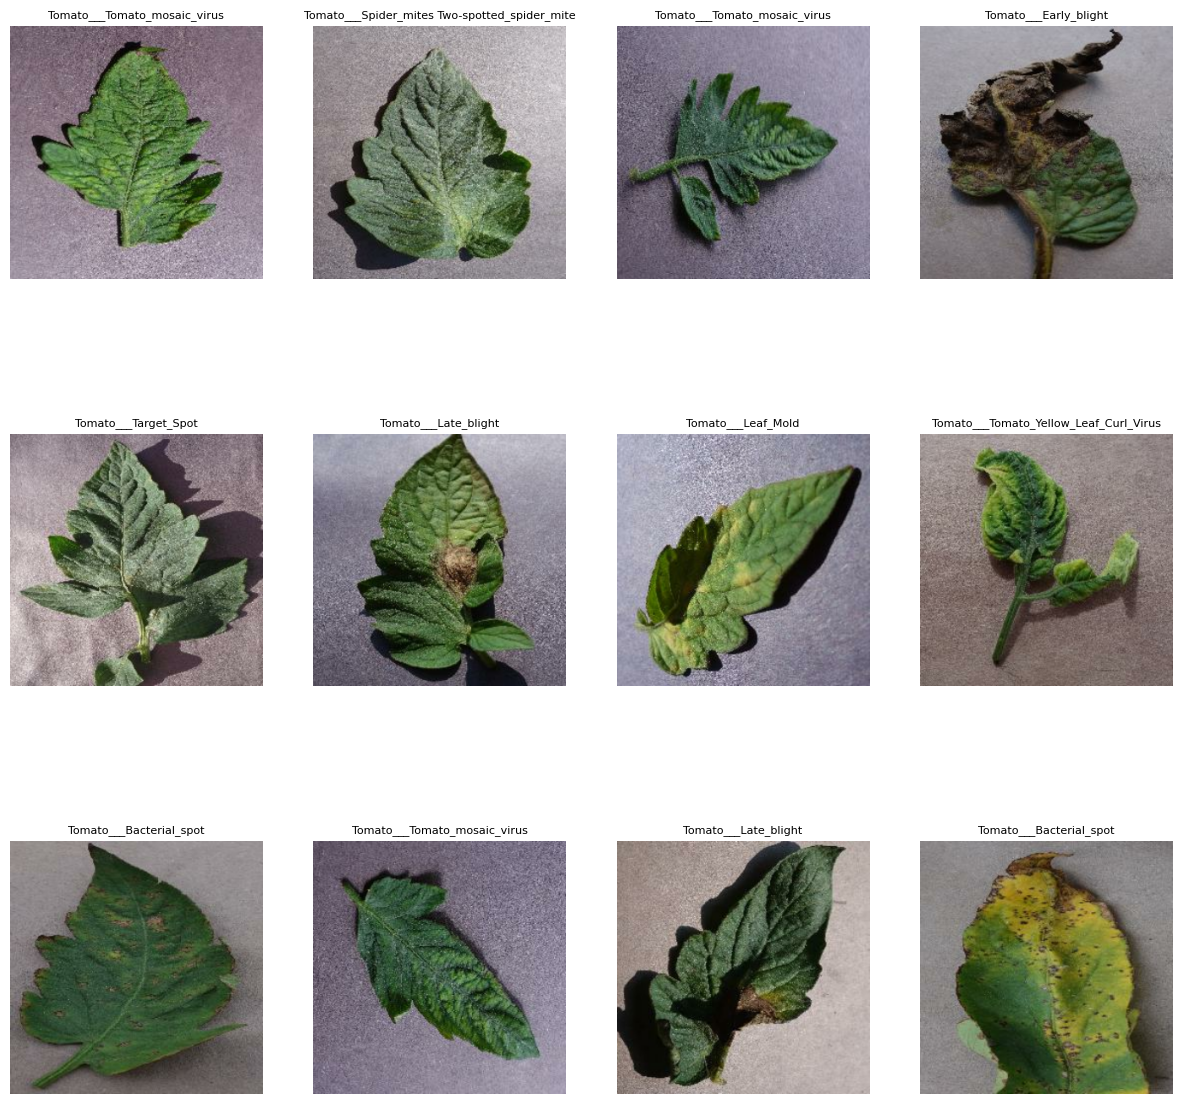

In [ ]:
plt.figure(figsize=(15, 15))

# Display the size of 12 random images in 1 batch
for image, labels in train_data.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]], fontsize=8) 
        plt.axis("off")

In [5]:
train_data = train_data.map(lambda x, y: (x / 255.0, (y, y)))
val_data = val_data.map(lambda x, y: (x / 255.0, (y, y)))

In [6]:
for batch in train_data:
    print(batch)
    break

(<tf.Tensor: shape=(32, 299, 299, 3), dtype=float32, numpy=
array([[[[0.40784314, 0.42352942, 0.42745098],
         [0.41399437, 0.42968065, 0.4336022 ],
         [0.42322117, 0.43890744, 0.442829  ],
         ...,
         [0.4730999 , 0.48878616, 0.50055087],
         [0.47058824, 0.4862745 , 0.49803922],
         [0.47058824, 0.4862745 , 0.49803922]],

        [[0.42322117, 0.43890744, 0.442829  ],
         [0.4269603 , 0.44264656, 0.44656813],
         [0.4335538 , 0.4492401 , 0.45316166],
         ...,
         [0.48343247, 0.49911875, 0.51088345],
         [0.48355412, 0.4992404 , 0.5110051 ],
         [0.4859663 , 0.50165254, 0.51341724]],

        [[0.44252083, 0.4582071 , 0.46212867],
         [0.44362658, 0.45931286, 0.46323442],
         [0.4457368 , 0.46142307, 0.46534464],
         ...,
         [0.48878613, 0.50447243, 0.51623714],
         [0.4890903 , 0.50477654, 0.51654124],
         [0.49019608, 0.5058824 , 0.5176471 ]],

        ...,

        [[0.5137255 , 0.5372549 

### III. Build model + Train model + Evaluate model

In [7]:
# Using Class

# Class to create Inception_F5 module (From figure 5 of the paper) version 1
class Inception_F5(layers.Layer):
    def __init__(self):
        super().__init__()
        
        # Branch 1: 1x1 convolution followed by two 3x3 convolutions
        self.branch1 = tf.keras.Sequential([
            layers.Conv2D(48, (1, 1), activation='relu'),
            layers.Conv2D(72, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(72, (3, 3), padding='same', activation='relu'),
        ])

        # Branch 2: 1x1 convolution followed by 3x3 convolution
        self.branch2 = tf.keras.Sequential([
            layers.Conv2D(48, (1, 1), activation='relu'),
            layers.Conv2D(72, (3, 3), padding='same', activation='relu'),
        ])

        # Branch 3: Average pooling followed by 1x1 convolution
        self.branch3 = tf.keras.Sequential([
            layers.AveragePooling2D((3, 3), (1, 1), padding='same'),
            layers.Conv2D(72, (1, 1), activation='relu'),
        ])

        # Branch 4: 1x1 convolution
        self.branch4 = layers.Conv2D(72, (1, 1), activation='relu')

    def call(self, inputs):
        branch1_output = self.branch1(inputs)
        branch2_output = self.branch2(inputs)
        branch3_output = self.branch3(inputs)
        branch4_output = self.branch4(inputs)
        
        # Combine branches
        output = layers.concatenate([branch1_output, branch2_output, branch3_output, branch4_output], axis=-1)
        return output

# Class to create Inception_F6 module (From figure 6 of the paper)
class Inception_F6(layers.Layer):
    def __init__(self, n=7):
        super().__init__()
        
        # Branch 1: 1x1 convolution followed by (1xn) and (nx1) convolutions
        self.branch1 = tf.keras.Sequential([
            layers.Conv2D(128, (1, 1), activation='relu'),
            layers.Conv2D(192, (1, n), padding='same', activation='relu'),
            layers.Conv2D(192, (n, 1), padding='same', activation='relu'),
            layers.Conv2D(192, (1, n), padding='same', activation='relu'),
            layers.Conv2D(192, (n, 1), padding='same', activation='relu'),
        ])

        # Branch 2: 1x1 convolution followed by (1xn) and (nx1) convolutions
        self.branch2 = tf.keras.Sequential([
            layers.Conv2D(128, (1, 1), activation='relu'),
            layers.Conv2D(192, (1, n), padding='same', activation='relu'),
            layers.Conv2D(192, (n, 1), padding='same', activation='relu'),
        ])

        # Branch 3: Average pooling followed by 1x1 convolution
        self.branch3 = tf.keras.Sequential([
            layers.AveragePooling2D((3, 3), (1, 1), padding='same'),
            layers.Conv2D(192, (1, 1), activation='relu'),
        ])

        # Branch 4: 1x1 convolution
        self.branch4 = layers.Conv2D(192, (1, 1), activation='relu')

    def call(self, inputs):
        branch1_output = self.branch1(inputs)
        branch2_output = self.branch2(inputs)
        branch3_output = self.branch3(inputs)
        branch4_output = self.branch4(inputs)
        
        # Combine branches
        output = layers.concatenate([branch1_output, branch2_output, branch3_output, branch4_output], axis=-1)
        return output


# Class to create Inception_F7 module (From figure 7 of the paper)
class Inception_F7(layers.Layer):
    def __init__(self):
        super().__init__()
        
        # Branch 1: 1x1 convolution followed by 3x3 convolution, then (1x3) and (3x1) convolutions
        self.branch1 = tf.keras.Sequential([
            layers.Conv2D(256, (1, 1), activation='relu'),
            layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        ])
        self.subbranch1_1 = layers.Conv2D(384, (1, 3), padding='same', activation='relu')
        self.subbranch1_2 = layers.Conv2D(384, (3, 1), padding='same', activation='relu')

        # Branch 2: 1x1 convolution followed by (1x3) and (3x1) convolutions
        self.branch2 = tf.keras.Sequential([
            layers.Conv2D(256, (1, 1), activation='relu'),
        ])
        self.subbranch2_1 = layers.Conv2D(384, (1, 3), padding='same', activation='relu')
        self.subbranch2_2 = layers.Conv2D(384, (3, 1), padding='same', activation='relu')

        # Branch 3: Average pooling followed by 1x1 convolution
        self.branch3 = tf.keras.Sequential([
            layers.AveragePooling2D((3, 3), (1, 1), padding='same'),
            layers.Conv2D(192, (1, 1), activation='relu'),
        ])

        # Branch 4: 1x1 convolution
        self.branch4 = layers.Conv2D(320, (1, 1), activation='relu')

    def call(self, inputs):
        branch1_output = self.subbranch1_1(self.branch1(inputs))
        branch1_output2 = self.subbranch1_2(self.branch1(inputs))

        branch2_output = self.subbranch2_1(self.branch2(inputs))
        branch2_output2 = self.subbranch2_2(self.branch2(inputs))

        branch3_output = self.branch3(inputs)
        branch4_output = self.branch4(inputs)

        # Combine branches
        output = layers.concatenate([branch1_output, branch1_output2, branch2_output, branch2_output2, branch3_output, branch4_output], axis=-1)
        return output

In [8]:
#Class to create the Auxiliary Classifier
class AuxiliaryClassifier(layers.Layer):
    def __init__(self, num_classes):
        super().__init__()
        self.avg_pool = layers.AveragePooling2D((5, 5), strides=(3, 3))
        self.conv = layers.Conv2D(128, (1, 1), padding='same', activation='relu')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024, activation='relu')
        self.dropout = layers.Dropout(0.7)
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.avg_pool(inputs)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


#Class to create Grid Size Reduction (Similar to figure in paper)
#Implementationt GridSizeReduction from the perspective of operations
class GridSizeReduction(layers.Layer):
    def __init__(self, out_fts):
        super().__init__()
        
        # Branch 1: 1x1 convolution followed by 3x3 convolutions (stride 1) and 3x3 convolutions (stride 2)
        self.branch1 = tf.keras.Sequential([
            layers.Conv2D(160 + out_fts[0], (1, 1), activation='relu'),
            layers.Conv2D(240 + out_fts[1], (3, 3), padding='same', activation='relu'),
            layers.Conv2D(240 + out_fts[1], (3, 3), strides=2, activation='relu'),
        ])
        
        # Branch 2: 1x1 convolution followed by 3x3 convolution (stride 2)
        self.branch2 = tf.keras.Sequential([
            layers.Conv2D(160 + out_fts[0], (1, 1), activation='relu'),
            layers.Conv2D(240 + out_fts[1], (3, 3), strides=2, activation='relu'),
        ])
        
        # Branch 3: Max pooling with stride 2
        self.branch3 = layers.MaxPool2D(pool_size=3, strides=2)
    
    def call(self, inputs):
        branch1_output = self.branch1(inputs)
        branch2_output = self.branch2(inputs)
        branch3_output = self.branch3(inputs)   
        
        # Combine branches
        output = layers.concatenate([branch1_output, branch2_output, branch3_output], axis=-1)
        return output

# Class to create InceptionV2 Model
class InceptionV2(tf.keras.Model):
    def __init__(self, input_shape=(299, 299, 3), num_classes = 1000):
        super().__init__()
        
        # Inception v2 Stem
        self.stem = tf.keras.Sequential([
            layers.Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape, activation='relu'),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((3, 3), strides=(2, 2)),
            layers.Conv2D(80, (3, 3), activation='relu'),
            layers.Conv2D(192, (3, 3), strides=(2, 2), activation='relu'),
            layers.Conv2D(288, (3, 3), padding='same', activation='relu'),
        ])

        # Inception modules
        self.inception_3a = Inception_F5()
        self.inception_3b = Inception_F5()
        self.inception_3c = Inception_F5()
        
        self.inception_reduction_a = GridSizeReduction([0, 0])

        self.inception_4a = Inception_F6()
        self.inception_4b = Inception_F6()
        self.inception_4c = Inception_F6()
        self.inception_4d = Inception_F6()
        self.inception_4e = Inception_F6()

        self.aux1 = AuxiliaryClassifier(num_classes)
              
        self.inception_reduction_b = GridSizeReduction([10, 16])
        
        self.inception_5a = Inception_F7()
        self.inception_5b = Inception_F7()
        
        # Global Average Pooling and Fully Connected Layer
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(0.5)
        self.fc = layers.Dense(num_classes, activation='softmax')


    def call(self, inputs):
        # Stem
        x = self.stem(inputs)
        
        # Inception modules
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.inception_3c(x)
        
        x = self.inception_reduction_a(x)
        
        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)

        aux1 = self.aux1(x)       
        
        x = self.inception_reduction_b(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        # Global Average Pooling và Fully Connected Layer
        x = self.global_avg_pool(x)
        x = self.dropout(x)
        outputs = self.fc(x)

        return outputs, aux1

# Model initialization
model_v2 = InceptionV2(input_shape=(299, 299, 3), num_classes=10)
model_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],  
                 loss_weights=[1.0, 0.3],  # Weights
                 metrics=['accuracy'])

# Show the architecture of the model
model_v2.build(input_shape=(None, 299, 299, 3))
model_v2.summary()

Model: "inception_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 35, 35, 288)       711184    
                                                                 
 inception_f5 (Inception_F5)  multiple                 178440    
                                                                 
 inception_f5_1 (Inception_F  multiple                 178440    
 5)                                                              
                                                                 
 inception_f5_2 (Inception_F  multiple                 178440    
 5)                                                              
                                                                 
 grid_size_reduction (GridSi  multiple                 1302800   
 zeReduction)                                                    
                                                      

In [9]:
history1 = model_v2.fit(train_data ,epochs = 25 , validation_data=val_data)

Epoch 1/25
313/313 [==============================] - 66s 174ms/step - loss: 2.9920 - output_1_loss: 2.3015 - output_2_loss: 2.3018 - output_1_accuracy: 0.0988 - output_2_accuracy: 0.1010 - val_loss: 2.9863 - val_output_1_loss: 2.2973 - val_output_2_loss: 2.2965 - val_output_1_accuracy: 0.1040 - val_output_2_accuracy: 0.1010
Epoch 2/25
313/313 [==============================] - 52s 167ms/step - loss: 2.5350 - output_1_loss: 1.9675 - output_2_loss: 1.8918 - output_1_accuracy: 0.2129 - output_2_accuracy: 0.2736 - val_loss: 2.3085 - val_output_1_loss: 1.8006 - val_output_2_loss: 1.6931 - val_output_1_accuracy: 0.3070 - val_output_2_accuracy: 0.3500
Epoch 3/25
313/313 [==============================] - 52s 167ms/step - loss: 1.9591 - output_1_loss: 1.5233 - output_2_loss: 1.4524 - output_1_accuracy: 0.3955 - output_2_accuracy: 0.4537 - val_loss: 1.5967 - val_output_1_loss: 1.2372 - val_output_2_loss: 1.1983 - val_output_1_accuracy: 0.5270 - val_output_2_accuracy: 0.5400
Epoch 4/25
313/313 

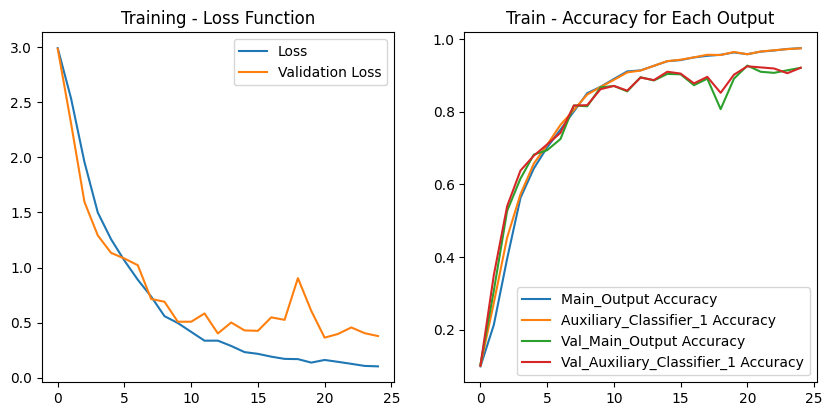

In [11]:
#Plot loss and accuracy of all 2 branches for train and valid sets

plt.figure(figsize=(10, 10))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'], label='Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

# Accuracy plot for each output
plt.subplot(2, 2, 2)
plt.plot(history1.history['output_1_accuracy'], label='Main_Output Accuracy')
plt.plot(history1.history['output_2_accuracy'], label='Auxiliary_Classifier_1 Accuracy')
plt.plot(history1.history['val_output_1_accuracy'], label='Val_Main_Output Accuracy')
plt.plot(history1.history['val_output_2_accuracy'], label='Val_Auxiliary_Classifier_1 Accuracy')
plt.legend()
plt.title('Train - Accuracy for Each Output')

plt.show()

#Note: loss và val_loss tổng được tính bằng cách tính tổng giữa trọng số (loss weight) được gán nhân với đầu ra (output) tương ứng của chúng

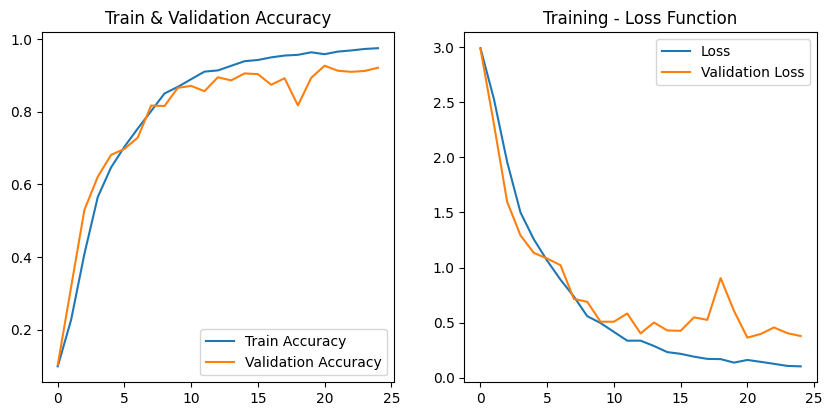

In [12]:
#Plot loss and accuracy by calculating the weighted average of all 2 branches for the train and valid sets

# Loss weight
weight_output_1 = 1
weight_output_2 = 0.3
total_weight = weight_output_1 + weight_output_2

# Calculate weighted accuracy for the train set
train_accuracy = []
for i in range(len(history1.history['output_1_accuracy'])):
    weighted_acc = (
        history1.history['output_1_accuracy'][i] * weight_output_1 +
        history1.history['output_2_accuracy'][i] * weight_output_2
    ) / total_weight
    train_accuracy.append(weighted_acc)

# Calculate the weighted val_accuracy value for the val set
val_accuracy = []
for i in range(len(history1.history['val_output_1_accuracy'])):
    weighted_val_acc = (
        history1.history['val_output_1_accuracy'][i] * weight_output_1 +
        history1.history['val_output_2_accuracy'][i] * weight_output_2
    ) / total_weight
    val_accuracy.append(weighted_val_acc)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Train & Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history1.history['loss'], label='Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.show()


In [19]:
model_v2.save('Inception_v2', save_format='tf')

INFO:tensorflow:Assets written to: Inception_v2\assets


INFO:tensorflow:Assets written to: Inception_v2\assets
